# Simple 2D Sparse GP
We will test to ensure that our sparse GP implementation works correctly in this notebook.

## Generate Syntethic Data
We generate a simple dataset for testing with inputs in the range [0, 200]. We'll use a sinusoidal function with some noise added.

In [1]:
import numpy as onp
import matplotlib.pyplot as plt

from sparse_gp import *
from plots import *

prng_key = random.key(0)

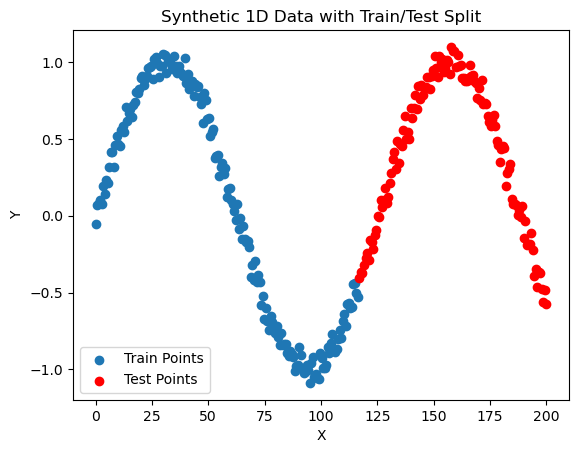

In [2]:
# Inputs
X = onp.linspace(0, 200, 300).reshape(-1, 1)

# Outputs: Sine function with noise
Y = onp.sin(X * 0.05) + 0.05 * onp.random.normal(size=X.shape)

# Training and testing split
X_train, Y_train = X[:175], Y[:175]
X_test, Y_test = X[175:], Y[175:]

# Plot data
plt.scatter(X_train, Y_train, label="Train Points")
plt.scatter(X_test, Y_test, label="Test Points", color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Synthetic 1D Data with Train/Test Split")
plt.show()

# Test Experiment 1
Test on 20 inducing points.

## Parameter Initialization

In [3]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=20)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [0, 0, 0, 0, 0]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 2
    hyperparams_spectralmixture = [0.1]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        variance = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)
#


# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train)

## Define the Optimization Loop for ELBO

In [4]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 500

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -245.01232154558807
Step 10, ELBO: -229.69461122663242
Step 20, ELBO: -215.65272994613582
Step 30, ELBO: -202.1830226773834
Step 40, ELBO: -190.1585154739652
Step 50, ELBO: -179.59516774240745
Step 60, ELBO: -170.36651380231598
Step 70, ELBO: -161.83939135183317
Step 80, ELBO: -151.04102010821452
Step 90, ELBO: -125.0793319725636
Step 100, ELBO: -107.84015713378443
Step 110, ELBO: -92.13686344061001
Step 120, ELBO: -77.08232739792217
Step 130, ELBO: -62.738534553308014
Step 140, ELBO: -49.29866687135106
Step 150, ELBO: -37.01889242530112
Step 160, ELBO: -26.182269572150233
Step 170, ELBO: -17.043417650243413
Step 180, ELBO: -9.752976416542992
Step 190, ELBO: -4.290143174756054
Step 200, ELBO: -0.44679020864387553
Step 210, ELBO: 2.1164829220307695
Step 220, ELBO: 3.7723738711695773
Step 230, ELBO: 4.84230053518246
Step 240, ELBO: 5.558517599632182
Step 250, ELBO: 6.067943703120449
Step 260, ELBO: 6.455065274384452
Step 270, ELBO: 6.765688279308364
Step 280, ELBO: 7.024212

In [5]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 0.005526012


## Predict and Plot the Results

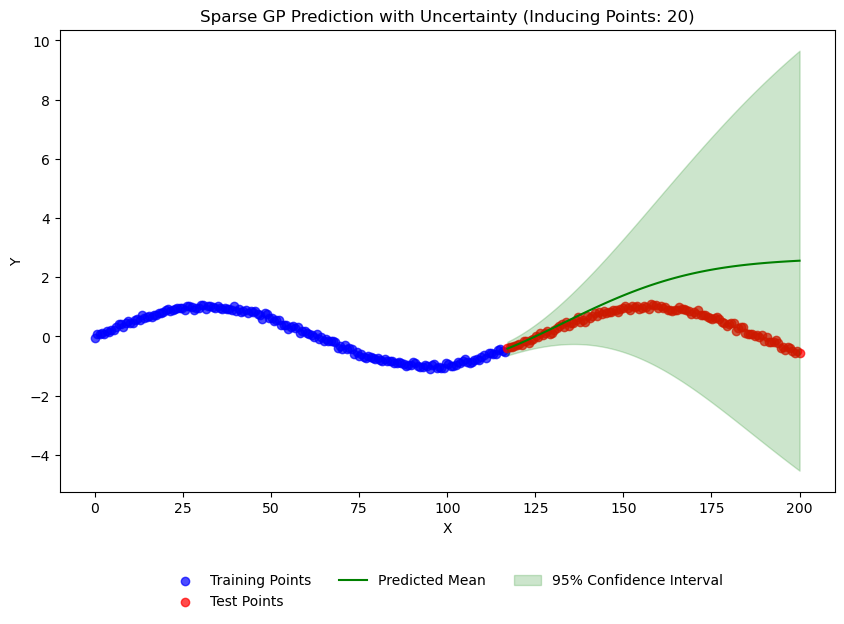

In [6]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, False)

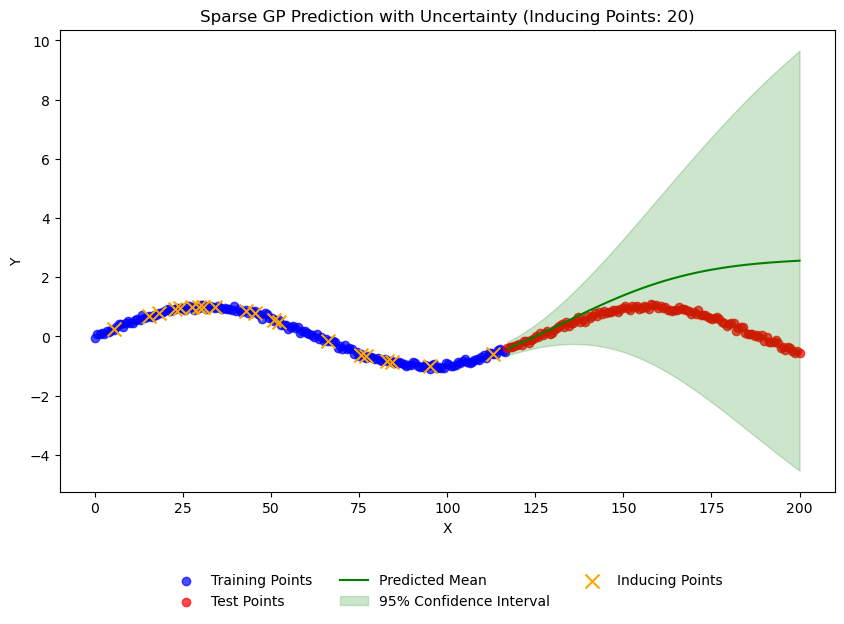

In [7]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [8]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

print(optimized_hyperparams)

Kernel Weights:
Kernel 1 (Squared-Exponential): 1.5693
Kernel 2 (Linear): 0.5354
Kernel 3 (Matérn): 0.8635
Kernel 4 (Sinusoidal): 0.8635
Kernel 5 (Spectral Mixture): 0.0083

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 40.87%
Kernel 2 (Linear): 13.94%
Kernel 3 (Matérn): 22.49%
Kernel 4 (Sinusoidal): 22.49%
Kernel 5 (Spectral Mixture): 0.22%

Other Hyperparameters:
Kernel 1 - Noise Variance: 0.0011
Kernel 1 - Signal Variance: 4.2658
Kernel 1 - Length Scale: 4923.2646
Kernel 2 - Noise Variance: 0.0011
Kernel 2 - Signal Variance: 1.4554
Kernel 3 - Noise Variance: 0.0011
Kernel 3 - Signal Variance: 2.3473
Kernel 3 - Length Scale: 22026.4648
Kernel 4 - Noise Variance: 0.0011
Kernel 4 - Signal Variance: 2.3473
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7181
Kernel 5 - Noise Variance: 0.0011

Spectral Mixture Kernel - Mixture 1:
Weight: 0.1132
Means: [1.495]
Variances: [49.016457]

Spectral Mixture Kernel - Mixture 2:
Weight: 0.1988
Means: [2.8812811]
Variances

## NLPD

In [9]:
def calculate_nlpd(X, Y, Z, hyperparams, model_fn):
    noise_variance = np.sum(np.array([optimized_hyperparams[i] for i in [3, 6, 8, 11, 15]]))
    posterior_mean, posterior_var = model_fn(X, X_train, Y_train, Z, hyperparams)
    nlpd = neg_log_predictive_density(Y, posterior_mean, posterior_var, noise_variance)
    return nlpd
#

train_nlpd = calculate_nlpd(X_train, Y_train, Z, optimized_hyperparams, sparse_gp_posterior_predictive)
test_nlpd = calculate_nlpd(X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 5.9191
Test NLPD: 5.9192


## MSE


In [10]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test, X_train, Y_train, Z, optimized_hyperparams)
mse = calculate_mse(Y_test, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 2.1427


## ELBO Maximization

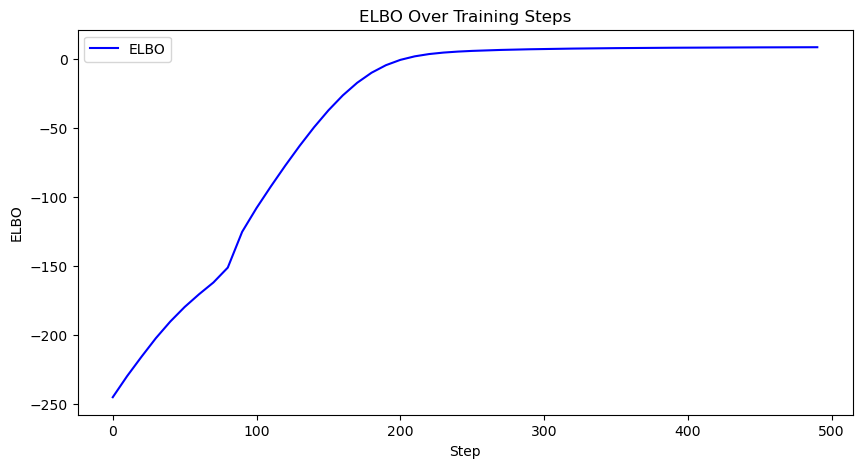

In [11]:
plot_elbo(history)

## Kernel Hyperparameters

Unchanged Hyperparameters:
 - Length Scale (Matern)
 - Length Scale (Sinusoidal)
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1


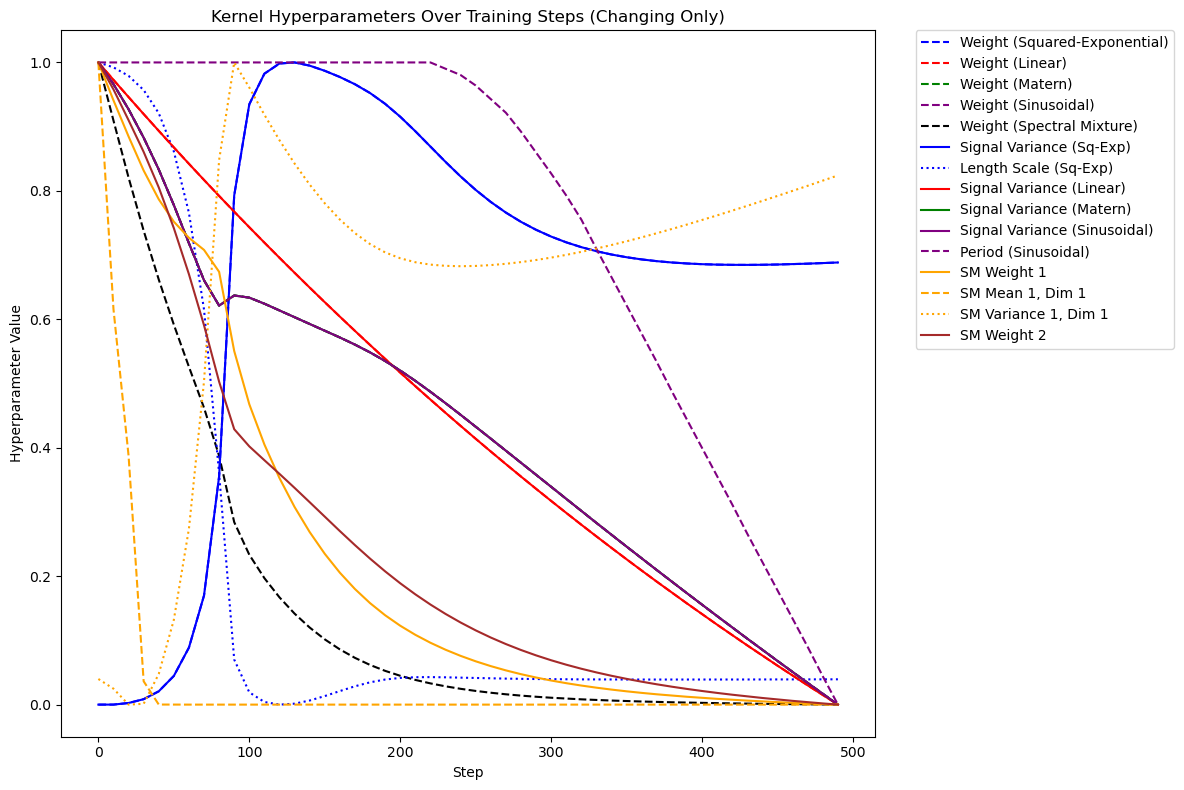

In [12]:
plot_kernel_hyperparameters(history, num_spectral_mixtures=2)

# Test Experiment 2
Test on 100 inducing points.

## Parameter Initialization

In [13]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=100)

# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train)

## Define the Optimization Loop for ELBO

In [14]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 500

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -254.52949468424566
Step 10, ELBO: -238.0567056778545
Step 20, ELBO: -222.83555041531116
Step 30, ELBO: -208.81495055407834
Step 40, ELBO: -195.7072445643646
Step 50, ELBO: -183.47691940220082
Step 60, ELBO: -171.70122596774016
Step 70, ELBO: -158.09363428192017
Step 80, ELBO: -139.30536383959955
Step 90, ELBO: -122.07321030938672
Step 100, ELBO: -106.25791152416237
Step 110, ELBO: -91.08020156275366
Step 120, ELBO: -76.44070778994232
Step 130, ELBO: -62.42428090963065
Step 140, ELBO: -49.19928448323989
Step 150, ELBO: -36.988454178981996
Step 160, ELBO: -26.044369088022876
Step 170, ELBO: -16.610890670092374
Step 180, ELBO: -8.867887051855291
Step 190, ELBO: -2.872927082323656
Step 200, ELBO: 1.4735145592821368
Step 210, ELBO: 4.414262931349214
Step 220, ELBO: 6.273987296445398
Step 230, ELBO: 7.380808669835517
Step 240, ELBO: 8.007980846879349
Step 250, ELBO: 8.35176103776243
Step 260, ELBO: 8.537883054526873
Step 270, ELBO: 8.640132854386962
Step 280, ELBO: 8.699096950

In [15]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 0.0052075703


## Predict and Plot the Results

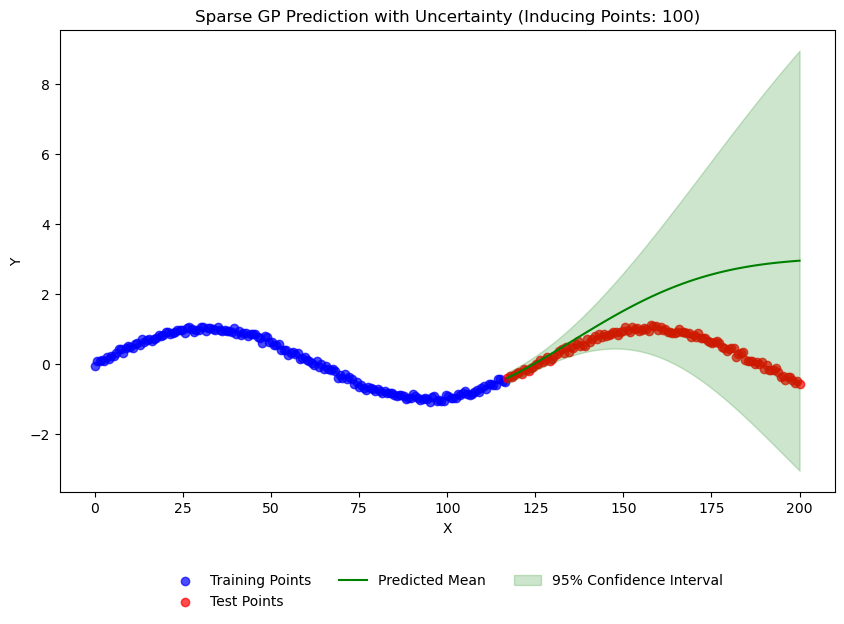

In [16]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, False)

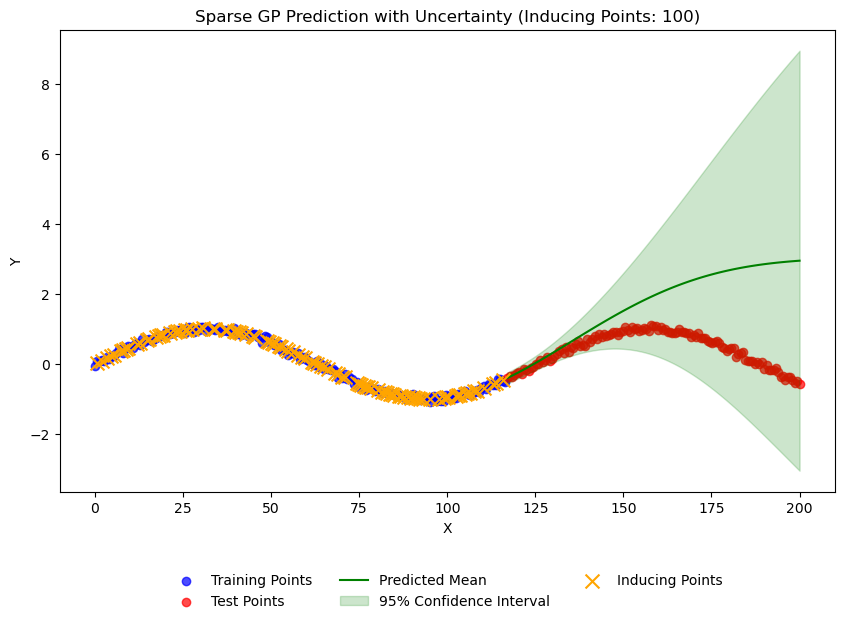

In [17]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [18]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

print(optimized_hyperparams)

Kernel Weights:
Kernel 1 (Squared-Exponential): 1.6550
Kernel 2 (Linear): 0.5355
Kernel 3 (Matérn): 0.8823
Kernel 4 (Sinusoidal): 0.8824
Kernel 5 (Spectral Mixture): 0.0036

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 41.81%
Kernel 2 (Linear): 13.53%
Kernel 3 (Matérn): 22.29%
Kernel 4 (Sinusoidal): 22.29%
Kernel 5 (Spectral Mixture): 0.09%

Other Hyperparameters:
Kernel 1 - Noise Variance: 0.0010
Kernel 1 - Signal Variance: 4.4987
Kernel 1 - Length Scale: 5023.5234
Kernel 2 - Noise Variance: 0.0010
Kernel 2 - Signal Variance: 1.4555
Kernel 3 - Noise Variance: 0.0010
Kernel 3 - Signal Variance: 2.3985
Kernel 3 - Length Scale: 22026.4648
Kernel 4 - Noise Variance: 0.0010
Kernel 4 - Signal Variance: 2.3985
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7208
Kernel 5 - Noise Variance: 0.0010

Spectral Mixture Kernel - Mixture 1:
Weight: 0.0840
Means: [1.495]
Variances: [38.230637]

Spectral Mixture Kernel - Mixture 2:
Weight: 0.1165
Means: [2.8812811]
Variances

## NLPD

In [19]:
train_nlpd = calculate_nlpd(X_train, Y_train, Z, optimized_hyperparams, sparse_gp_posterior_predictive)
test_nlpd = calculate_nlpd(X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 5.9191
Test NLPD: 5.9192


## MSE

In [20]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test, X_train, Y_train, Z, optimized_hyperparams)
mse = calculate_mse(Y_test, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 2.8520


## ELBO Maximization


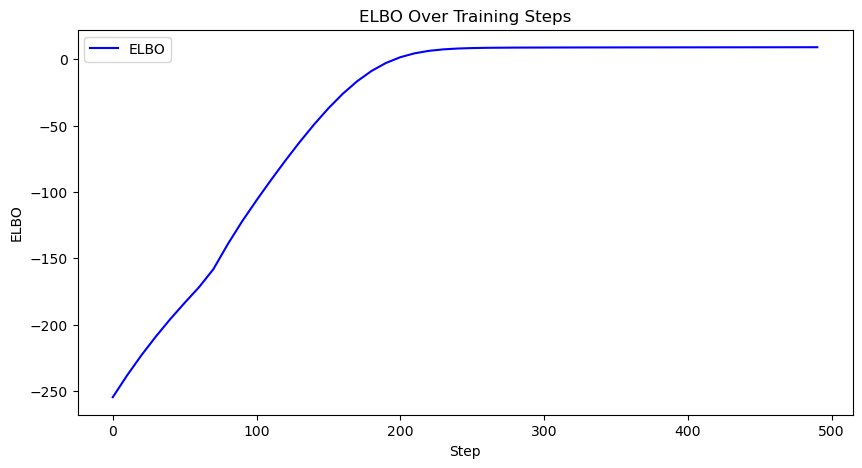

In [21]:
plot_elbo(history)

## Kernel Hyperparameters

Unchanged Hyperparameters:
 - Length Scale (Matern)
 - Length Scale (Sinusoidal)
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1


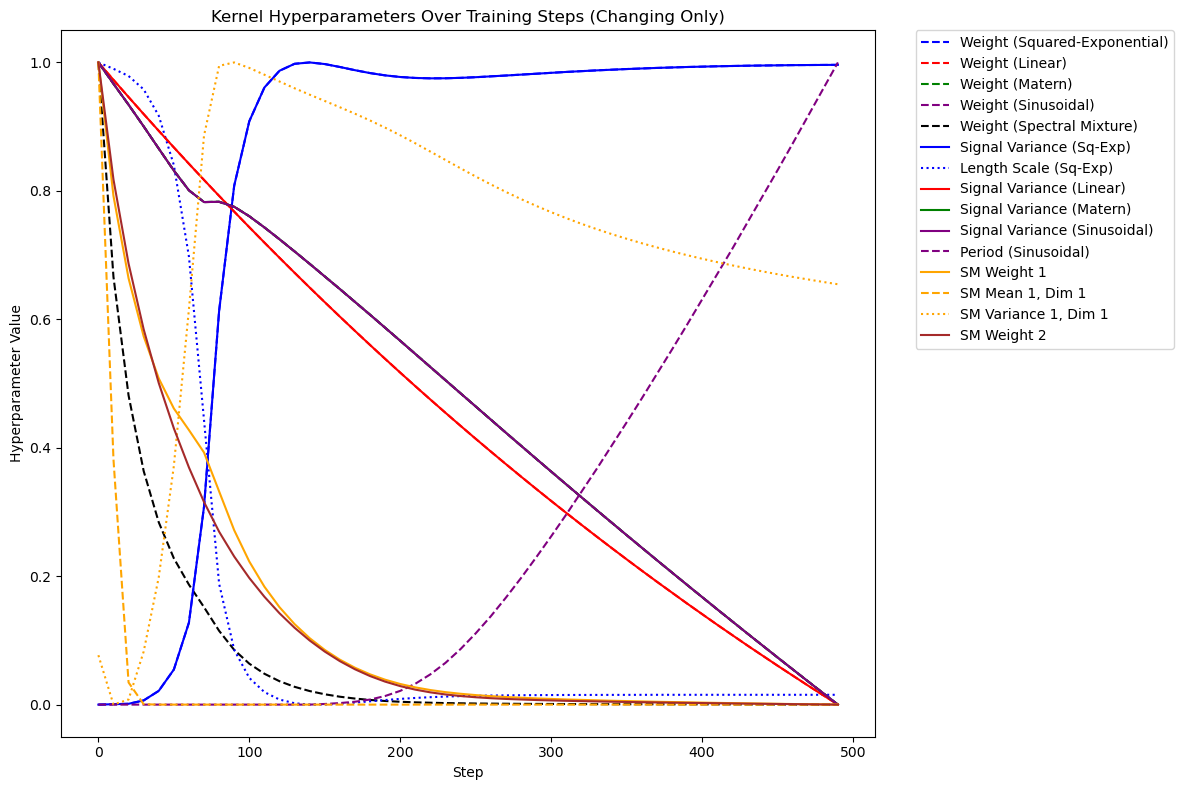

In [22]:
plot_kernel_hyperparameters(history, num_spectral_mixtures=2)